In [20]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

from utils import init_weights, BatchNorm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initialization

Consider the following network:

In [21]:
class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(10, 100, bias=False),
                                    nn.ReLU(),
                                    nn.Linear(100, 100, bias=False),
                                    nn.ReLU(),
                                    nn.Linear(100, 100, bias=False),
                                    nn.ReLU(),
                                    nn.Linear(100, 1, bias=False),
                                   )
    
    def forward(self, x):
        return self.layers(x)

    
def hook_fun(module, input, output):
    activations.append(output)

Execute the following cells and observe the statistics of the layer outputs:

In [22]:
x = torch.randn(100, 10)

In [23]:
net = Network()

In [24]:
def hook_fun(module, input, output):   #check for register_forward_hook in pytorch doc
    activations.append(output)

In [25]:
hooks = []
activations = []

for layer in net.layers:
    hook = layer.register_forward_hook(hook_fun) #this is not executed now, it creates a hook and will be executed when forward is called
    hooks.append(hook)

with torch.no_grad():
    res = net(x)

for hook in hooks:
    hook.remove()

In [26]:
activations[0]

tensor([[-1.0854, -0.5616, -0.0383,  ..., -1.1148, -1.2427,  0.0649],
        [-0.2108,  0.1053, -0.1061,  ..., -0.8528, -0.6115, -0.1493],
        [ 0.0297,  0.0939, -0.0682,  ...,  0.1928,  0.1836,  0.6685],
        ...,
        [-1.1945,  0.0416, -1.1942,  ..., -0.2057, -1.1583,  0.6876],
        [-1.5688, -0.6927, -0.3207,  ...,  0.5855,  0.0181,  0.8927],
        [-0.8156, -0.0302, -0.2507,  ...,  0.7925, -0.7699,  0.5052]])

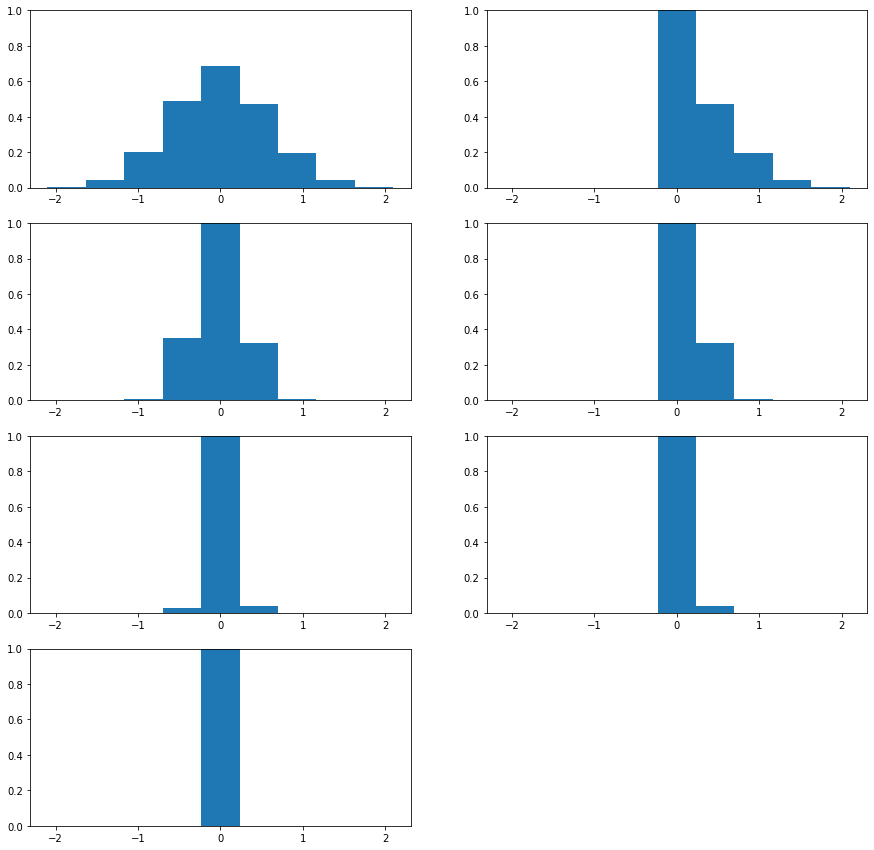

In [27]:
plt.figure(figsize=(15, 15))

for i, act in enumerate(activations):
    plt.subplot(4, 2, i+1)
    plt.hist(act.reshape(-1), bins=9, density=True, range=(-2.1,2.1))
    plt.gca().set_ylim(0, 1)


In [28]:
print(res.var())

tensor(0.0005)


# Kaiming Initialization

Implement the initialization method by Kaiming He as introduced in the lecture, also see https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf. Therefore complete the ``init_weights`` function in ``utils.py``. For recursively applying a method to the network's modules, we use ``torch.nn.Module.apply``, https://pytorch.org/docs/stable/nn.html?highlight=apply#torch.nn.Module.apply.

In [29]:
net.apply(init_weights);

In [30]:
hooks = []
activations = []

for layer in net.layers:
    hook = layer.register_forward_hook(hook_fun)
    hooks.append(hook)

with torch.no_grad():
    res = net(x)

for hook in hooks:
    hook.remove()

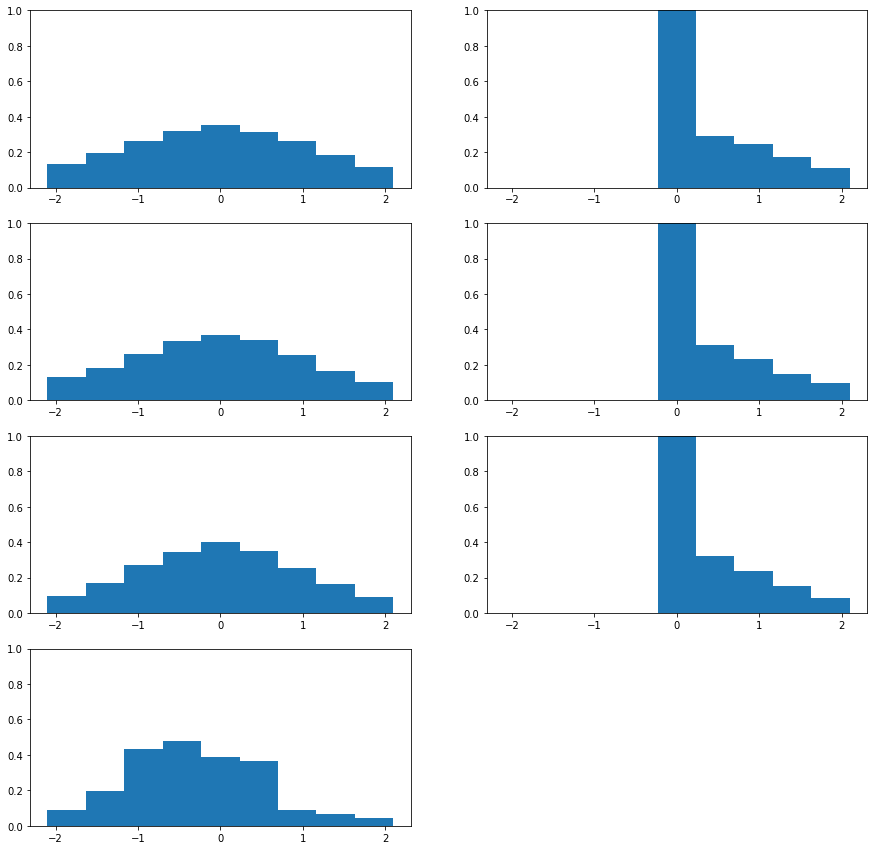

In [31]:
plt.figure(figsize=(15, 15))

for i, act in enumerate(activations):
    plt.subplot(4, 2, i+1)
    plt.hist(act.reshape(-1), bins=9, density=True, range=(-2.1,2.1))
    plt.gca().set_ylim(0, 1)


In [32]:
print(res.var())

tensor(0.7499)


In [33]:
print(net.layers[6].weight.var() * net.layers[6].in_features / 2)

tensor(1.1740, grad_fn=<DivBackward0>)


# Batch Normalization

From the lecture you already know a different strategy for stabilizing the training of deep networks: Batch normalization. Consider an input of size $B \times C$. For each channel $C$ the batch norm layer takes all $B$ values of the batch elements and normalizes them accordingly. Afterwards it rescales the output with a learnable deviation and adds a bias parameter per channel, see e.g. https://pytorch.org/docs/stable/nn.html?highlight=apply#torch.nn.tchNorm2d and https://arxiv.org/abs/1502.03167. At inference time, the batch norm layer 'normalizes' one input image by using running estimates of the deviations and biases of the inputs so far. Implement ``BatchNorm`` in ``utils.py``. Initialize the learnable parameters in such a way that the layer initially returns the channel-wise normed input. At the first forward pass, set the running mean and variance to those of the first mini-batch. Afterwards update them by taking the weighted sum of the current and the running means and variances. Further details are provided in the comments in ``utils.py``.

In [34]:
bn = BatchNorm(10)

torch.manual_seed(0)
x1 = torch.randn(4, 10)
x2 = torch.randn(4, 10)
x3 = torch.randn(4, 10)

with torch.no_grad():
    res1 = bn(x1)
    bn.theta_sigma.data = bn.theta_sigma * 2
    bn.theta_mu.data = bn.theta_mu + 1
    res2 = bn(x2)
    bn.eval()
    res3 = bn(x3)

assert (res1.mean(dim=0) - 0).abs().max()<1e-6 and (res1.var(dim=0) - 1).abs().max()<1e-3
assert (res2.mean(dim=0) - 1).abs().max()<1e-6 and (res2.var(dim=0) - 4).abs().max()<1e-3
assert (res3.mean() - 1.3529).abs().max()<1e-3 and (res3.var() - 4.6663).abs().max()<1e-3